In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

##### Import data into DataFrame

In [2]:
df_Q4 = pd.read_excel(r'Groupon\Q4_2013_Groupon_North_America_Data_XLSX (1).xlsx', sheet_name = 'Q4 2013 Raw Data')
df_summary = pd.read_excel(r'Groupon\Q4_2013_Groupon_North_America_Data_XLSX (1).xlsx', sheet_name = 'Historical Data')

### 1. Billing and Units Sold during Missing Period

##### Clean and arrange the data

In [6]:
start_date_sum = df_Q4.groupby(['Start Date', 'Segment'], as_index=False).sum()
start_date_sum['Billings'] = start_date_sum['Billings']
start_date_sum_missing = start_date_sum[(start_date_sum['Start Date'] >= np.datetime64('2013-09-20')) & (start_date_sum['Start Date'] <= np.datetime64('2013-12-10'))]

Text(0.5, 1.0, 'Units Sold by Date')

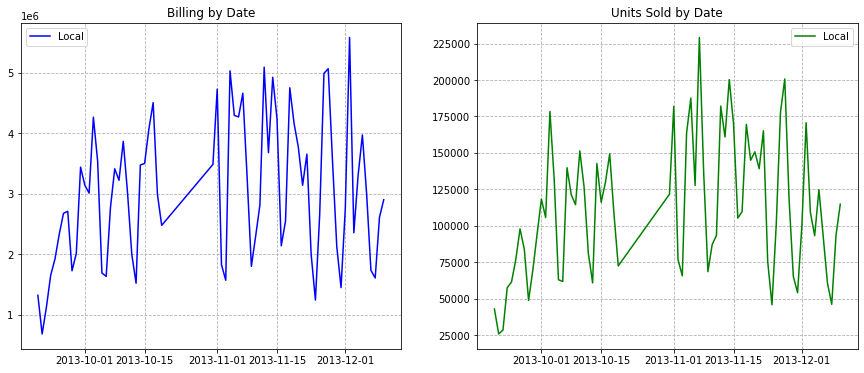

In [7]:
seg = 'Local'
seg_date = start_date_sum_missing[start_date_sum_missing['Segment'] == seg]['Start Date'].reset_index(drop=True)
seg_billing_data = start_date_sum_missing[start_date_sum_missing['Segment'] == seg]['Billings'].reset_index(drop=True)
seg_unit_data = start_date_sum_missing[start_date_sum_missing['Segment'] == seg]['Units Sold'].reset_index(drop=True)

plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
plt.plot(seg_date, seg_billing_data, color='blue', markersize=5, label = seg)
plt.legend()
plt.grid(linestyle='--')
plt.title('Billing by Date')
ax2 = plt.subplot(1,2,2)
plt.plot(seg_date, seg_unit_data, color='green', markersize=5, label = seg)
plt.legend()
plt.grid(linestyle='--')
plt.title('Units Sold by Date')

##### Find the samllest point in each period. Based on the chart above, the smallest point should be smaller than $3M.Also, as shown in the chart, we could find the cyclicity in the sales for the product listed in Oct and Nov.

In [45]:
index_max = seg_date.index.max()
min_billing_date = []
min_unit_date = []

for i in range(1, index_max):
    curr_billing_data = seg_billing_data[i]
    last_billing_data = seg_billing_data[i - 1]
    next_billing_data = seg_billing_data[i + 1]
    
    curr_unit_data = seg_unit_data[i]
    last_unit_data = seg_unit_data[i - 1]
    next_unit_data = seg_unit_data[i + 1]
#     Find the date point for billing
    if (curr_billing_data < last_billing_data) and (curr_billing_data < next_billing_data) and curr_billing_data < 3*10**6:
        min_billing_date.append(seg_date[i].date())

#     Find the date point for Units Sold
    if (curr_unit_data < last_unit_data) and (curr_unit_data < next_unit_data) and curr_unit_data < 110000:
        min_unit_date.append(seg_date[i].date())
    else:
        continue

print("Minimum Billing Dates: " + str(min_billing_date) + '\n')
print("Minimum Unit Dates: " + str(min_unit_date))

Minimum Billing Dates: [datetime.date(2013, 9, 21), datetime.date(2013, 9, 28), datetime.date(2013, 10, 6), datetime.date(2013, 10, 13), datetime.date(2013, 10, 19), datetime.date(2013, 11, 3), datetime.date(2013, 11, 9), datetime.date(2013, 11, 16), datetime.date(2013, 11, 24), datetime.date(2013, 11, 30), datetime.date(2013, 12, 3), datetime.date(2013, 12, 8)]

Minimum Unit Dates: [datetime.date(2013, 9, 21), datetime.date(2013, 9, 28), datetime.date(2013, 10, 2), datetime.date(2013, 10, 6), datetime.date(2013, 10, 13), datetime.date(2013, 10, 19), datetime.date(2013, 11, 3), datetime.date(2013, 11, 9), datetime.date(2013, 11, 16), datetime.date(2013, 11, 24), datetime.date(2013, 11, 30), datetime.date(2013, 12, 4), datetime.date(2013, 12, 8)]


In the date points for Units Sold, we need to remove 10/2/2013 because it's not the end of the cycle. For Units Sold and Billing, we may need to remove 12/3/2013, 12/4/2013, and 12/8/2013 because the trends they belong to are not obvious. Therefore, The date should be 9/28/2013, 10/6/2013, 10/13/2013, 11/3/2013, 11/9/2013, 11/16/2013, 11/24/2013, 11/30/2013, 12/3/2013, 12/8/2013

In [104]:
lst = []
for i in min_billing_date:
    lst.append(i.isoformat())
print(lst)

['2013-09-21', '2013-09-28', '2013-10-06', '2013-10-13', '2013-10-19', '2013-11-03', '2013-11-09', '2013-11-16', '2013-11-24', '2013-11-30', '2013-12-03', '2013-12-08']


##### Research on the Rule of the Cycle

In [24]:
full_list1 = min_date[1:4]
full_list2 = min_date[5:len(min_date) - 2]
period_length = []
for lst in ([full_list1, full_list2]):
    curr_list = lst
    for i in range(1, len(lst), 1):
        period_length.append((lst[i] - lst[i-1]).days)

missing_length = (min_date[5] - min_date[3]).days
average_length = sum(period_length) / len(period_length)
print('The lengths of each cycle: ' + str(period_length))
print('The length of cycle to be researched: ' + str(missing_length))
print('The average length is ' + str(average_length) + ' days')

The lengths of each cycle: [8, 7, 6, 7, 8, 6]
The length of cycle to be researched: 21
The average length is 7.0 days


Thus, there are 21/7 = 3 cycles from 10/13 thru 11/3. We could add the amount during this period by using the average of the sales from the cycles with complete data.

In [70]:
date1 = full_list1[0]
date2 = full_list1[-1]
date3 = full_list2[0]
date4 = full_list2[-1]
sale_complete = []
unit_complete = []
sale_missing_part = []
unit_missing_part = []
for i in seg_date.index:
    curr_date = seg_date[i].date()
    if (curr_date > date1 and curr_date < date2) or (curr_date > date3 and curr_date < date4):
        sale_complete.append(seg_billing_data[i])
        unit_complete.append(seg_unit_data[i])
    elif curr_date > date2 and curr_date < date3:
        sale_missing_part.append(seg_billing_data[i])
        unit_missing_part.append(seg_unit_data[i])
    else:
        continue

date_length = ((date4 - date3) + (date3 - date1)).days

sale_sum = sum(sale_complete)
sale_missing_sum = sum(sale_missing_part)
unit_sum = sum(unit_complete)
unit_missing_sum = sum(unit_missing_part)
sale_avg = sale_sum / date_length
unit_avg = unit_sum / date_length
sale_estimate = sale_avg * missing_length
unit_estimate = unit_avg * missing_length
sale_missing_part = sale_estimate - sale_missing_sum
unit_missing_part = unit_estimate - unit_missing_sum
print("The estimated billings for the cycles between 10/13 and 11/3: %.2f"%sale_estimate)
print("The estimated billings for the product starting between 10/20 and 10/30: %.2f"%sale_missing_part)
print("The estimated units sold for the cycles between 10/13 and 11/3: %.2f"%unit_estimate)
print("The estimated units sold for the product starting between 10/20 and 10/30: %.2f"%unit_missing_part)

The estimated sales for the cycles between 10/13 and 11/3: 44403121.53
The estimated sales for the product starting between 10/20 and 10/30: 13335994.76
The estimated units sold for the cycles between 10/13 and 11/3: 1711704.50
The estimated units sold for the product starting between 10/20 and 10/30: 612559.90


### 2. Number of New Deal during the missing period

Text(0.5, 1.0, 'Number of New Deal by Date')

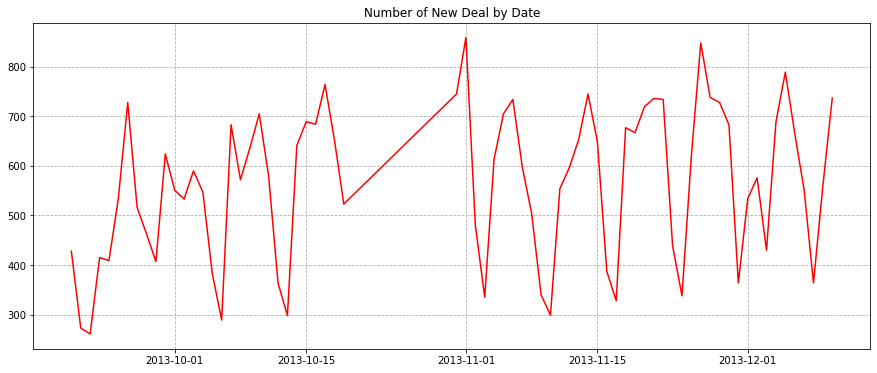

In [118]:
start_date_count = df_Q4.groupby(['Start Date', 'Segment'], as_index=False).count()
start_date_count_missing = start_date_count[(start_date_count['Start Date'] >= np.datetime64('2013-09-20')) & (start_date_count['Start Date'] <= np.datetime64('2013-12-10'))]
start_date_count_missing = start_date_count_missing[start_date_count_missing['Segment'] == seg]
start_date_count_missing = start_date_count_missing[['Start Date', 'Segment', 'Deal ID']]

seg_date2 = start_date_count_missing['Start Date'].reset_index(drop=True)
seg_data2 = start_date_count_missing['Deal ID'].reset_index(drop=True)

plt.figure(figsize=(15,6))
plt.plot(seg_date2, seg_data2, color = 'red')
plt.grid(linestyle = '--')
plt.title('Number of New Deal by Date')

We could see from the chart above, the number of new deal on each day in Oct and Nov also shows the cyclicity. Therefore, the missing part will be added with average number.

In [91]:
# Search the date of minimum point in each cycle
index_max2 = seg_date2.index.max()
count_deal_date = [] 
for i in range(1, index_max2, 1):
    curr_count = seg_data2[i]
    last_count = seg_data2[i - 1]
    next_count = seg_data2[i + 1]
    
    if (curr_count < last_count) and (curr_count < next_count) and curr_count < 500:
        count_deal_date.append(seg_date2[i].date())
    else:
        continue

print("Minimum New Deal Dates: " + str(count_deal_date))

Minimum New Deal Dates: [datetime.date(2013, 9, 22), datetime.date(2013, 9, 24), datetime.date(2013, 9, 29), datetime.date(2013, 10, 6), datetime.date(2013, 10, 13), datetime.date(2013, 11, 3), datetime.date(2013, 11, 10), datetime.date(2013, 11, 17), datetime.date(2013, 11, 24), datetime.date(2013, 11, 30), datetime.date(2013, 12, 3), datetime.date(2013, 12, 8)]


Here, only complete cycle will be considered. Therefore, by checking the chart above, The dates that are chosen are 9/29/2013, 10/6/2013, 10/13/2013, 11/3/2013, 11/10/2013, 11/17/2013, 11/24/2013, 11/30/2013

In [116]:
seg_date2_list1 = count_deal_date[2:5]
seg_date2_list2 = count_deal_date[5:len(count_deal_date) - 2]

deal_date1 = seg_date2_list1[0] 
deal_date2 = seg_date2_list1[-1]
deal_date3 = seg_date2_list2[0]
deal_date4 = seg_date2_list2[-1]
deal_complete = []
deal_missing_part = []
for i in seg_date2.index:
    curr_date2 = seg_date2[i].date()
    if (curr_date2 > deal_date1 and curr_date2 < deal_date2) or (curr_date2 > deal_date3 and curr_date2 < deal_date4):
        deal_complete.append(seg_data2[i])
    elif curr_date2 > deal_date2 and curr_date2 < deal_date3:
        deal_missing_part.append(seg_data2[i])
    else:
        continue

date_length = ((deal_date4 - deal_date3) + (deal_date3 - deal_date1)).days

deal_sum = sum(deal_complete)
deal_missing_sum = sum(deal_missing_part)
deal_avg = deal_sum / date_length
deal_estimate = deal_avg * missing_length
deal_missing_part = deal_estimate - deal_missing_sum
print("The estimated number of new deals for the cycles between 10/13 and 11/3: %.0f"%deal_estimate)
print("The estimated number of new deals starting between 10/20 and 10/30: %.0f"%deal_missing_part)

The estimated number of new deals for the cycles between 10/13 and 11/3: 7685
The estimated number of new deals starting between 10/20 and 10/30: 1646


### 3. Pattern Analysis

Text(0.5, 1.0, 'Units Sold by Date')

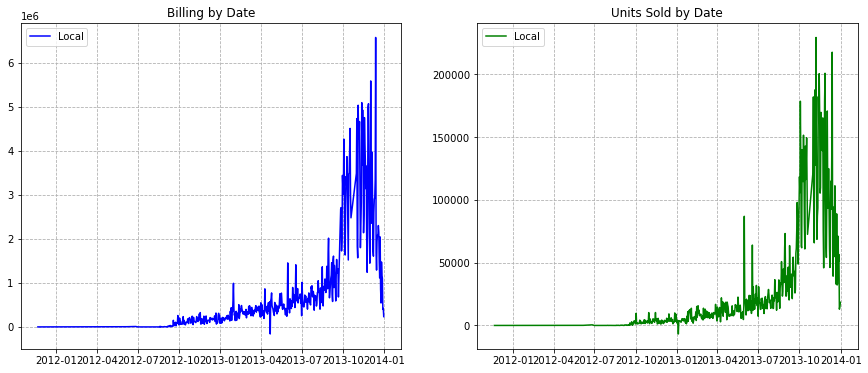

In [8]:
start_date_sum_missing = start_date_sum
seg = 'Local'
seg_date = start_date_sum_missing[start_date_sum_missing['Segment'] == seg]['Start Date'].reset_index(drop=True)
seg_billing_data = start_date_sum_missing[start_date_sum_missing['Segment'] == seg]['Billings'].reset_index(drop=True)
seg_unit_data = start_date_sum_missing[start_date_sum_missing['Segment'] == seg]['Units Sold'].reset_index(drop=True)

plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
plt.plot(seg_date, seg_billing_data, color='blue', markersize=5, label = seg)
plt.legend()
plt.grid(linestyle='--')
plt.title('Billing by Date')
ax2 = plt.subplot(1,2,2)
plt.plot(seg_date, seg_unit_data, color='green', markersize=5, label = seg)
plt.legend()
plt.grid(linestyle='--')
plt.title('Units Sold by Date')

Text(0.5, 1.0, 'Number of New Deal by Date')

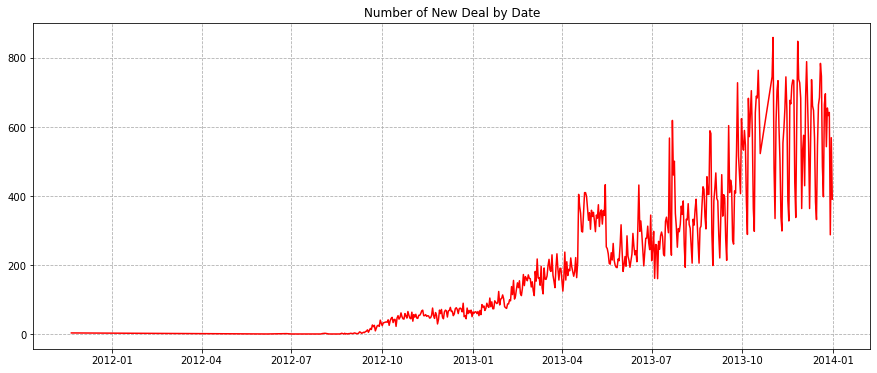

In [9]:
start_date_count = df_Q4.groupby(['Start Date', 'Segment'], as_index=False).count()
start_date_count_missing = start_date_count[(start_date_count['Start Date'] >= np.datetime64('2013-09-20')) & (start_date_count['Start Date'] <= np.datetime64('2013-12-10'))]
start_date_count_missing = start_date_count_missing[start_date_count_missing['Segment'] == seg]
start_date_count_missing = start_date_count_missing[['Start Date', 'Segment', 'Deal ID']]

seg_date2 = start_date_count_missing['Start Date'].reset_index(drop=True)
seg_data2 = start_date_count_missing['Deal ID'].reset_index(drop=True)

plt.figure(figsize=(15,6))
plt.plot(seg_date2, seg_data2, color = 'red')
plt.grid(linestyle = '--')
plt.title('Number of New Deal by Date')